[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]
Knots: [   0.    0.    0.  100.  200.  300.  400.  500.  600.  700.  800.  900.
 1000. 1000. 1000.]
Number of basis functions: 12
Support of B-spline Bump 3: [1.00, 299.30]
Support of B-spline Bump 4: [100.10, 399.40]
Support of B-spline Bump 5: [200.20, 499.50]
Support of B-spline Bump 6: [300.30, 599.60]
Support of B-spline Bump 7: [400.40, 699.70]
Support of B-spline Bump 8: [500.50, 799.80]
Support of B-spline Bump 9: [600.60, 899.90]
Support of B-spline Bump 10: [700.70, 999.00]


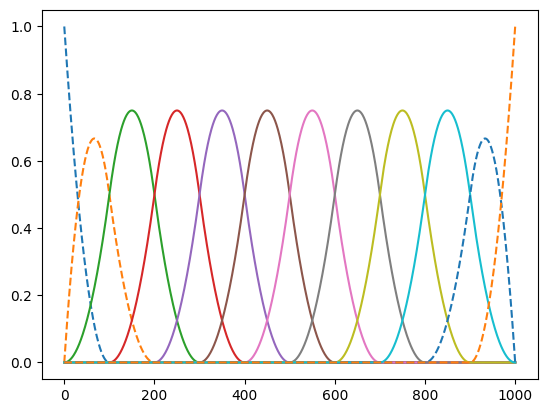

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import BSpline

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

# For the cosine bumps, we set them to be 100 wide with 50 jumps, and optimize the height
# For the B-spline, we use the equivalent knots, and just evaluate the Hann function
# For the Gaussian, we use the same centers, and standard deviation 50

# ---- Helper functions ----

def sum_bumps_with_coeffs(coeffs, bumps):
    return sum(c * b for c, b in zip(coeffs, bumps))

# ---- Parameters ----

window_size = 1000
cosine_width = 100
cosine_step = 50
cosine_centers = np.arange(cosine_width // 2, window_size, cosine_step)

x = np.linspace(0, window_size, 1000)
bounds=(0, np.inf) # avoiding overshoot #(-np.inf, np.inf)

# ---- Cosine Optimization (Fixed Width, Varying Height) ----
"""
def objective_heights(coeffs, bumps, target):
    return sum_bumps_with_coeffs(coeffs, bumps) - target

def cosine_bump(x, center, width):
    t = (x - center) / width
    return 0.5 * (1 + np.cos(np.pi * t)) * (np.abs(t) <= 1)

cosine_bumps = [cosine_bump(x, c, cosine_width / 2) for c in cosine_centers]
initial_heights = np.ones(len(cosine_centers))
for i, bump in enumerate(cosine_bumps):
    plt.plot(x, bump, label=f'Cosine Bump {i+1}')
plt.show()
A_hann = np.stack(cosine_bumps, axis=1)  # shape: (num_points, num_bumps)
"""
# ---- B-Spline Projection (Fixed Basis) ----

spline_degree = 3  # 7
density = 2
#num_knots = density*19-(density-1) +2  #  19*3 plus the 2 endpoints that will be repeated then removed. 19 is equal to the number of cosine bumps.
#print(num_knots)
num_knots = 11 #spline_degree +2
knots = np.linspace(0, window_size, num_knots)
print(knots)
knots = knots[1:-1]  # remove the endpoints
"""def cluster_knots(knots, window_size):  # cluster knots towards the center
    downscaled_knots = knots/window_size
    for i, dsknot in enumerate(downscaled_knots):
        if dsknot <= 0.5:
            dsknot = 0.5*np.sin(np.pi*dsknot)
        else:
            dsknot = 1-0.5*np.sin(np.pi*dsknot)
        knots[i] = window_size* dsknot
    return knots"""
from scipy.stats import beta
def cluster_knots(knots, window_size, concentration):
    if concentration <= 1:
        raise ValueError("Concentration must be larger than 1.")
    normalized_knots = knots/window_size
    clustered_normalized_knots = beta.ppf(normalized_knots, concentration, concentration)  # inverse beta cdf
    clustered_knots = window_size * clustered_normalized_knots
    return clustered_knots
#knots = cluster_knots(knots, window_size, 2)
knots = np.concatenate((
    [0] * (spline_degree+1),  #[knots[0]] * (spline_degree+1),  # left clamped
    knots,
    [window_size] * (spline_degree+1)#[knots[-1]] * (spline_degree+1)  # right clamped
))
print(f"Knots: {knots}")
num_basis = len(knots) - spline_degree  - 1
print(f"Number of basis functions: {num_basis}")
identity_coefs = np.eye(num_basis)
bspline_bumps = [BSpline(knots, coef, spline_degree)(x) for coef in identity_coefs]
for i, bump in enumerate(bspline_bumps):
    if i < spline_degree or i > num_basis -spline_degree -1:
        plt.plot(x, bspline_bumps[i], '--', label=f'B-spline Bump {i+1}')
    else:
        plt.plot(x, bspline_bumps[i], label=f'B-spline Bump {i+1}')
        y = bspline_bumps[i]
        non_zero_indices = np.where(np.abs(y) > 0)[0]
        support_start = x[non_zero_indices[0]]  # The first x value where y is significant
        support_end = x[non_zero_indices[-1]]   # The last x value where y is significant
        print(f"Support of B-spline Bump {i+1}: [{support_start:.2f}, {support_end:.2f}]")
plt.show()
#bspline_bumps = bspline_bumps[2:-2]  # Remove the first 2 and last 2 B-spline bumps
A_bspline = np.stack(bspline_bumps, axis=1)  # shape: (num_points, num_bumps)
A_bspline_small = A_bspline[0:-1:10, :]
# ---- B-Spline Approximation (Direct via Sampling) ----

#spline_degree = 3
#num_basis = len(cosine_centers)  # or however many you'd like
#num_knots = num_basis + spline_degree + 1

# Uniform knots across the window
#knots = np.linspace(0, window_size, num_knots - 2 * spline_degree)
#knots = np.concatenate((
#    [knots[0]] * spline_degree,  # left clamped
#    knots,
#    [knots[-1]] * spline_degree  # right clamped
#))

# Greville abscissae = mean of inner knots (natural control point locations)
greville = np.array([np.mean(knots[i+1:i+1+spline_degree]) for i in range(num_basis)])
greville[greville < 0] = 0
greville[greville >= window_size] = window_size -1
#print(f"Greville abscissae: {greville}")

# ---- Gaussian Optimization -----

"""def objective_gaussian(params, x, centers, target):
    num = len(centers)
    heights = params[:num]
    widths = params[num:]
    approx = sum(h * gaussian_bump(x, c, w) for h, c, w in zip(heights, centers, widths))
    return approx - target"""
"""
gaussian_width = 25

def objective_gaussian(params, x, centers, target):
    num = len(centers)
    heights = params
    widths = num*[gaussian_width]
    approx = sum(h * gaussian_bump(x, c, w) for h, c, w in zip(heights, centers, widths))
    return approx - target

def gaussian_bump(x, center, width):
    return np.exp(-0.5 * ((x - center) / width) ** 2)

gaussian_bumps = [gaussian_bump(x, c, gaussian_width) for c in cosine_centers]

initial_heights = np.ones(len(cosine_centers))
#initial_widths = np.full(len(cosine_centers), cosine_width / 2)
#initial_params = np.concatenate([initial_heights, initial_widths])
initial_params = initial_heights
for i, bump in enumerate(gaussian_bumps):
    plt.plot(x, bump, label=f'Gaussian Bump {i+1}')
plt.show()
A_gaussian = np.stack(gaussian_bumps, axis=1)  # shape: (num_points, num_bumps)
"""
# ---- Bezier ----
"""from scipy.special import comb  # binomial coefficients
def bernstein_basis(n, x):
    # Returns a matrix of shape (len(x), n+1)
    return np.array([comb(n, i) * (x**i) * ((1 - x)**(n - i)) for i in range(n+1)]).T
n = num_knots-1  # degree of Bezier curve
A_bezier = bernstein_basis(n, x/1000)
for i, bump in enumerate(A_bezier.T):
    plt.plot(x, bump, label=f'Bezier Bump {i+1}')"""

#############
bspline_bumps = bspline_bumps[spline_degree:-spline_degree]

Target width: 111
364.7300949598247
Elapsed time: 0.0018 seconds
[1.32820267e-153 4.53523932e-123 3.94754734e-099 8.54427998e-080
 7.00512002e-064 1.24691206e-050 1.57028228e-039 3.21286688e-030
 1.95003289e-022 5.47681442e-016 9.92155797e-011 1.48639779e-006
 2.21390721e-003 3.74289166e-001 7.85427239e+000 2.15422974e+001
 7.85427239e+000 3.74289166e-001 2.21390721e-003 1.48639779e-006
 9.92155797e-011 5.47681442e-016 1.95003289e-022 3.21286688e-030
 1.57028228e-039 1.24691206e-050 7.00512002e-064 8.54427998e-080
 3.94754734e-099 4.53523932e-123 1.32820267e-153]
Elapsed time: 0.0008 seconds
Target width: 397
28.051669003673652
Elapsed time: 0.0018 seconds
[2.02045567e-11 3.76966407e-09 2.27389311e-07 6.23442394e-06
 9.51366030e-05 9.20068318e-04 6.15701248e-03 3.03284325e-02
 1.15002026e-01 3.46975035e-01 8.53797529e-01 1.74543276e+00
 3.00531644e+00 4.40145868e+00 5.51963163e+00 5.94975758e+00
 5.51963163e+00 4.40145868e+00 3.00531644e+00 1.74543276e+00
 8.53797529e-01 3.46975035e-01

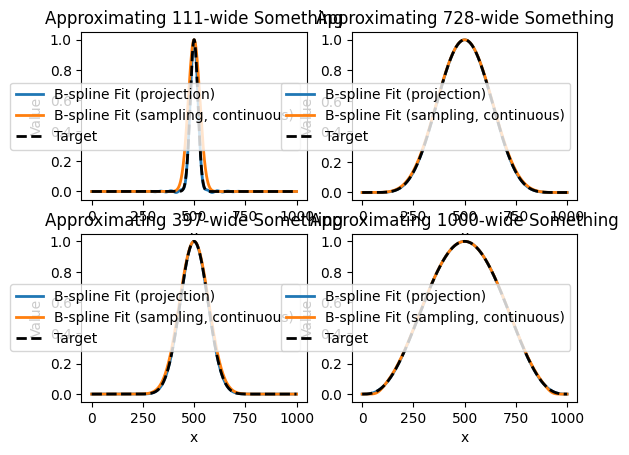

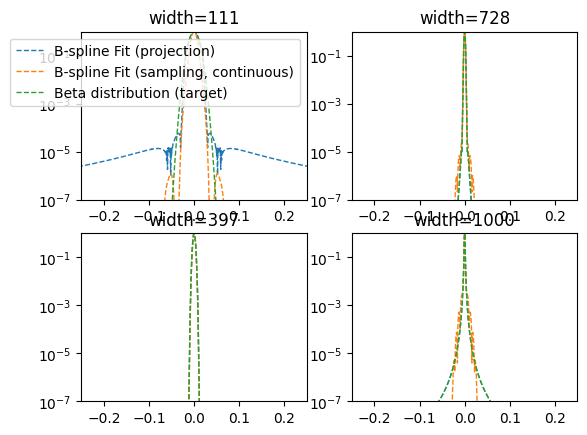

In [ ]:
from scipy.signal import windows
from scipy.special import iv
from scipy.stats import norm

target_width = [111, 397, 728, 1000]
subs = [2, 2]
i = 0
j = 0
fig1, axes1 = plt.subplots(subs[0], subs[1])
fig2, axes2 = plt.subplots(subs[0], subs[1])
for width in target_width:
    if i%subs[0] == 0 and i != 0:
        j += 1
        i = 0
    print(f"Target width: {width}")

    # ---- Target: Window of specified width ----
    half_width = width // 2
    #target = 0.5 * (1 + np.cos(np.pi * (x - 500) / half_width))
    #target[np.abs(x - 500) > half_width] = 0
    """beta = 8.6         # Shape parameter (controls trade-off between mainlobe width and sidelobe level)
    window = windows.kaiser(width, beta)  #np.kaiser(width, beta)
    target = np.zeros_like(x)
    target[500 - half_width:500 + half_width] = window
    print(len(target[500 - half_width:500 + half_width]))
    print(len(window))
    def kaiser_value(x, N, beta):
        return iv(0, beta * np.sqrt(1 - ((2 * x / (N - 1)) - 1) ** 2)) / iv(0, beta)"""
    a = 1/2* ( (3000/width)**2 -1 )
    print(a)
    b = a
    target = beta.pdf(x/1000, a, b)

    sigma = width / 6
    normal = norm.pdf(x, loc=500, scale=sigma)
    #target = normal

    hann = 0.5 * (1 + np.cos(np.pi * (x - 500) / half_width))
    hann[np.abs(x - 500) > half_width] = 0

    # Cosine bumps
    #tic()
    #res_cosine = least_squares(objective_heights, initial_heights, args=(cosine_bumps, target), bounds=bounds)
    #cosine_fit = sum_bumps_with_coeffs(res_cosine.x, cosine_bumps)
    #print(res_cosine.x)

    #h_opt, *_ = np.linalg.lstsq(A_hann, target, rcond=None)
    #cosine_fit = A_hann @ h_opt
    #toc()

    # Project Hann onto B-spline basis using least squares
    #res_bspline = least_squares(objective_heights, np.ones(num_basis), args=(bspline_bumps, target_hann), bounds=bounds)
    #bspline_fit = sum_bumps_with_coeffs(res_bspline.x, bspline_bumps)
    tic()
    h_opt, *_ = np.linalg.lstsq(A_bspline, target, rcond=None)  # A_bspline_small, [0:-1:10]
    bspline_fit = A_bspline @ h_opt
    #print(res_bspline.x)
    toc()

    #tic()
    # Sample Hann at point closest to Greville abscissae 
    #idcs = greville.astype(int)
    #idcs[idcs < 0] = 0
    #idcs[idcs >= window_size] = window_size - 1
    #target_at_greville = target[idcs]
    # Evaluate final spline approximation
    #bspline_fit_2 = BSpline(knots, target_at_greville, spline_degree)(x)
    #target_at_greville = target_at_greville[2:-2]  # Remove the first 2 and last 2 B-spline bumps
    #bspline_fit_2_disc = sum_bumps_with_coeffs(target_at_greville, bspline_bumps)
    #toc()

    # Sample Hann at Greville abscissae
    tic()
    #target_at_greville = kaiser_value(greville-500+half_width, width, beta)
    target_at_greville = beta.pdf(greville/1000, a, b)
    #target_at_greville = 0.5 * (1 + np.cos(np.pi * (greville - 500) / half_width))
    #target_at_greville[np.abs(greville - 500) > half_width] = 0
    #print(target_at_greville)
    target_at_greville = target_at_greville[spline_degree:-spline_degree]
    print(target_at_greville)
    """if i == 0 and j == 0:
        # set all values except the middle to 0
        target_at_greville[0:spline_degree] = 0
        target_at_greville[-spline_degree:] = 0"""

    #bspline_fit_2_cont = sum_bumps_with_coeffs(target_at_greville, bspline_bumps)
    bspline_fit_2_cont = BSpline(knots, 
                                 np.concatenate([spline_degree*[0], target_at_greville, spline_degree*[0]]), 
                                 spline_degree)(x)
    toc()

    #tic()
    #h_opt, *_ = np.linalg.lstsq(A_gaussian, target, rcond=None)
    #gaussian_fit = A_gaussian @ h_opt
    
    #res_gaussian = least_squares(objective_gaussian, initial_params, args=(x, cosine_centers, target), bounds=bounds)
    #res_gaussian = least_squares(objective_heights, initial_heights, args=(gaussian_bumps, target), bounds=bounds)
    #opt_heights = res_gaussian.x[:len(cosine_centers)]
    #opt_heights = res_gaussian.x
    #opt_widths = res_gaussian.x[len(cosine_centers):]
    #gaussian_fit = sum(gaussian_bump(x, c, w) * h for c, w, h in zip(cosine_centers, opt_widths, opt_heights))
    #gaussian_fit = sum(gaussian_bump(x, c, w) * h for c, w, h in zip(cosine_centers, len(cosine_centers)*[gaussian_width], opt_heights))
    #gaussian_fit = sum_bumps_with_coeffs(res_gaussian.x, gaussian_bumps)
    #toc()

    #tic()
    #h_opt, *_ = np.linalg.lstsq(A_bezier, target, rcond=None)
    #bezier_fit = A_bezier @ h_opt
    #toc()

    # ---- Plot ----

    #axes1[i, j].plot(x, cosine_fit / np.max(cosine_fit), label='Cosine Fit (height only)', linewidth=2)
    axes1[i, j].plot(x, bspline_fit / np.max(bspline_fit), label='B-spline Fit (projection)', linewidth=2)
    #plt.plot(x, bspline_fit_2_disc / np.max(bspline_fit_2_disc), label='B-spline Fit (sampling, discrete)', linewidth=2)
    axes1[i, j].plot(x, bspline_fit_2_cont / np.max(bspline_fit_2_cont), label='B-spline Fit (sampling, continuous)', linewidth=2)
    #plt.plot(x, gaussian_fit / np.max(gaussian_fit), label='Gaussian Fit (height + width)', linewidth=2)
    #plt.plot(x, bezier_fit / np.max(bezier_fit), label='Bezier Fit (height + width)', linewidth=2)
    axes1[i, j].plot(x, target / np.max(target), 'k--', label='Target', linewidth=2)
    axes1[i, j].set_title(f"Approximating {width}-wide Something")
    axes1[i, j].set_xlabel('x')
    axes1[i, j].set_ylabel('Value')
    axes1[i, j].legend()
    #axes1[i, j].grid(True)
    #axes1[i, j].tight_layout()
    #axes1[i, j].show()


    """# Compute second derivative (numerically)
    dx = x[1] - x[0]  # Assuming uniform spacing
    #cosine_fit_2nd_derivative = np.gradient(np.gradient(cosine_fit, dx), dx)
    bspline_fit_2nd_derivative = np.gradient(np.gradient(bspline_fit, dx), dx)
    bspline_fit_2_disc_2nd_derivative = np.gradient(np.gradient(bspline_fit_2_disc, dx), dx)
    bspline_fit_2_cont_2nd_derivative = np.gradient(np.gradient(bspline_fit_2_cont, dx), dx)
    gaussian_fit_2nd_derivative = np.gradient(np.gradient(gaussian_fit, dx), dx)
    target_2nd_derivative = np.gradient(np.gradient(target, dx), dx)

    # Plot the second derivatives
    plt.figure(figsize=(12, 6))
    #plt.plot(x, cosine_fit_2nd_derivative / np.max(np.abs(cosine_fit_2nd_derivative)), label='Cosine Fit 2nd Derivative', linewidth=2)
    plt.plot(x, bspline_fit_2nd_derivative / np.max(np.abs(bspline_fit_2nd_derivative)), label='B-spline Fit (projection) 2nd Derivative', linewidth=2)
    plt.plot(x, bspline_fit_2_disc_2nd_derivative / np.max(np.abs(bspline_fit_2_disc_2nd_derivative)), label='B-spline Fit (sampling, discrete) 2nd Derivative', linewidth=2)
    plt.plot(x, bspline_fit_2_cont_2nd_derivative / np.max(np.abs(bspline_fit_2_cont_2nd_derivative)), label='B-spline Fit (sampling, continuous) 2nd Derivative', linewidth=2)
    plt.plot(x, gaussian_fit_2nd_derivative / np.max(np.abs(gaussian_fit_2nd_derivative)), label='Gaussian Fit 2nd Derivative', linewidth=2)
    plt.plot(x, target_2nd_derivative / np.max(np.abs(target_2nd_derivative)), 'k--', label='Target 2nd Derivative', linewidth=2)
    plt.title(f"Second Derivative of Approximations to {width}-wide Window")
    plt.xlabel('x')
    plt.ylabel('2nd Derivative Value (normalized)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()"""

    def plot_dfts(x, *signals, labels, title="DFT Magnitudes", width=None):
        n = len(x)
        freqs = np.fft.fftshift(np.fft.fftfreq(n, d=(x[1] - x[0])))
        
        #plt.figure(figsize=(12, 6))
        for sig, label in zip(signals, labels):
            dft = np.abs(np.fft.fftshift(np.fft.fft(sig)))
            dft /= np.max(dft)  # Normalize
            axes2[i, j].plot(freqs, dft, '--', label=label, linewidth=1)  # 

        axes2[i, j].set_title(f"width={width}")
        #plt.title(f"DFTs of Approximations (Width = {width})" if width else title)
        #plt.xlabel("Frequency (Hz or normalized units)")
        #plt.ylabel("Magnitude (normalized)")
        axes2[i, j].set_yscale('log')
        axes2[i, j].set_ylim(1e-7, 1)
        #axes[i, j].set_ylim(1e-4, 1)
        axes2[i, j].set_xlim(-0.25, 0.25)
        #axes[i, j].set_xlim(-0.01, 0.01)
        if i==0 and j==0:
            axes2[i, j].legend()
        #plt.grid(True)
        #plt.tight_layout()
        #plt.show()

    plot_dfts(
        x,
        #hann,
        #normal,
        #cosine_fit,
        bspline_fit,
        #bspline_fit_2_disc,
        bspline_fit_2_cont,
        #gaussian_fit,
        #bezier_fit,
        target,
        labels=[
            #'Hann of the same width',
            #'Normal of the same width',
            #'Cosine Fit (height only)',
            'B-spline Fit (projection)',
            #'B-spline Fit (sampling, discrete)',
            'B-spline Fit (sampling, continuous)',
            #'Gaussian Fit (height + width)',
            "Beta distribution (target)"  #'Target'
        ],
        width=width
    )
    i += 1

Degree: 2
39
Target width: 107
Target width: 397
Target width: 728
Target width: 1000
Degree: 2
39
Target width: 107
Target width: 397
Target width: 728
Target width: 1000
Degree: 2
39
Target width: 107
Target width: 397
Target width: 728
Target width: 1000
Degree: 2
39
Target width: 107
Target width: 397
Target width: 728
Target width: 1000


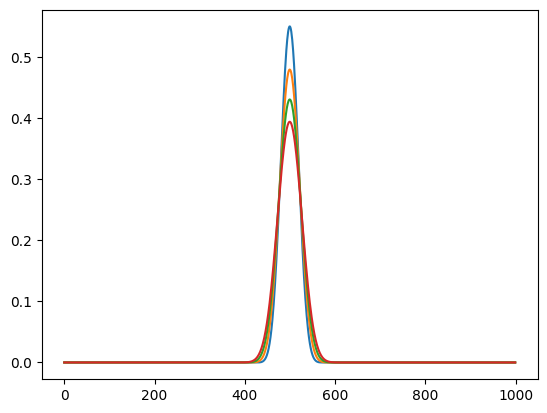

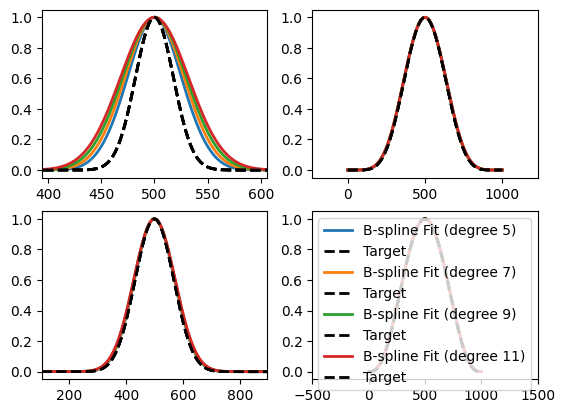

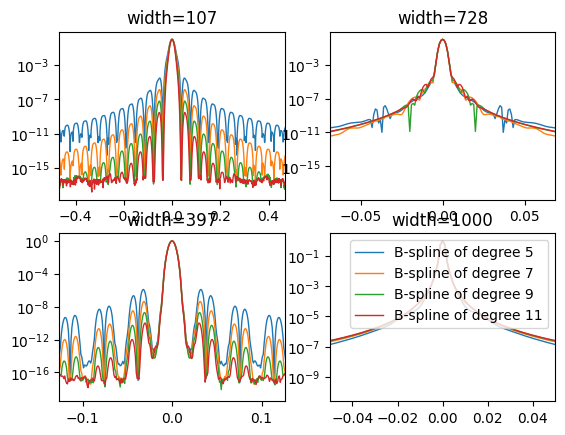

In [119]:
from scipy.interpolate import make_lsq_spline
from scipy.optimize import nnls

# Try different degrees of the B-spline
subs = [2, 2]
fig0, axes0 = plt.subplots(1, 1)
fig1, axes1 = plt.subplots(subs[0], subs[1])
fig2, axes2 = plt.subplots(subs[0], subs[1])
target_width = [107, 397, 728, 1000]
for k in range(5, 11+2, 2):
    print(f"Degree: {i}")
    # ---- B-Spline Projection (Fixed Basis) ----
    spline_degree = k
    density = 2
    num_knots = density*19-(density-1) +2  #  19*3 plus the 2 endpoints that will be repeated then removed. 19 is equal to the number of cosine bumps.
    print(num_knots)
    knots = np.linspace(0, window_size, num_knots)
    knots = knots[1:-1]  # remove the endpoints
    knots = np.concatenate((
        [0] * (spline_degree+1),  #[knots[0]] * (spline_degree+1),  # left clamped
        knots,
        [window_size] * (spline_degree+1)#[knots[-1]] * (spline_degree+1)  # right clamped
    ))
    num_basis = len(knots) - spline_degree - 1
    identity_coefs = np.eye(num_basis)
    bspline_bumps = [BSpline(knots, coef, spline_degree)(x) for coef in identity_coefs]
    #bspline_bumps = bspline_bumps[spline_degree:-spline_degree]
    axes0.plot(bspline_bumps[num_basis//2])

    greville = np.array([np.mean(knots[i+1:i+1+spline_degree]) for i in range(num_basis)])
    greville[greville < 0] = 0
    greville[greville >= window_size] = window_size -1

    i = 0
    j = 0
    for width in target_width:
        if i%subs[0] == 0 and i != 0:
            j += 1
            i = 0
        
        print(f"Target width: {width}")

        # ---- Target: Window of specified width ----
        half_width = width // 2
        a = 1/2* ( (3000/width)**2 -1 )
        b = a
        target = beta.pdf(x/1000, a, b)

        target_at_greville = beta.pdf(greville/1000, a, b)
        #target_at_greville = target_at_greville[spline_degree:-spline_degree]
        bspline_fit = sum_bumps_with_coeffs(target_at_greville, bspline_bumps)

        # Least squares fit through the Greville abisscae
        #lsq_spline = make_lsq_spline(greville, target_at_greville, knots, k)
        #lsq_spline_fit = lsq_spline(x)
        #axes1[i, j].plot(x, lsq_spline_fit / np.max(lsq_spline_fit), '--', label=f'B-spline lsq (degree {spline_degree})', linewidth=2)
        """B = np.zeros((len(greville), num_basis))
        for l in range(num_basis):
            coef = np.zeros(num_basis)
            coef[l] = 1.0
            spline_i = BSpline(knots, coef, k)
            B[:, l] = spline_i(greville)
        coeffs, rnorm = nnls(B, target_at_greville)
        nnspline = BSpline(knots, coeffs, k)
        lsq_spline_fit = nnspline(x)
        axes1[i, j].plot(x, lsq_spline_fit / np.max(lsq_spline_fit), '--', label=f'B-spline lsq (degree {spline_degree})', linewidth=2)"""

        # ---- Plot ----
        axes1[i, j].plot(x, bspline_fit / np.max(bspline_fit), label=f'B-spline Fit (degree {spline_degree})', linewidth=2)
        axes1[i, j].plot(x, target / np.max(target), 'k--', label='Target', linewidth=2)
        axes1[i, j].set_xlim(500-2*half_width, 500+2*half_width)
        if i==1 and j==1:
            axes1[i, j].legend()
        #axes1[i, j].set_title(f"Approximating {width}-wide Something")
        #axes1[i, j].set_xlabel('x')
        #axes1[i, j].set_ylabel('Value')
        #axes1[i, j].legend()
        def plot_dfts(x, *signals, labels, title="DFT Magnitudes", width=None):
            n = len(x)
            freqs = np.fft.fftshift(np.fft.fftfreq(n, d=(x[1] - x[0])))
            
            for sig, label in zip(signals, labels):
                dft = np.abs(np.fft.fftshift(np.fft.fft(sig)))
                dft /= np.max(dft)  # Normalize
                axes2[i, j].plot(freqs, dft, label=label, linewidth=1)  # '--', 

            axes2[i, j].set_title(f"width={width}")
            axes2[i, j].set_yscale('log')
            axes2[i, j].set_xlim(-50/width, 50/width)
            if i==1 and j==1:
                axes2[i, j].legend()

        plot_dfts(
            x,
            bspline_fit,
            #target,
            labels=[
                f'B-spline of degree {spline_degree}',
                #"Beta distribution (target)"
            ],
            width=width
        )

        i += 1


Target width: 111
364.7300949598247
Elapsed time: 0.0029 seconds
Elapsed time: 0.0012 seconds


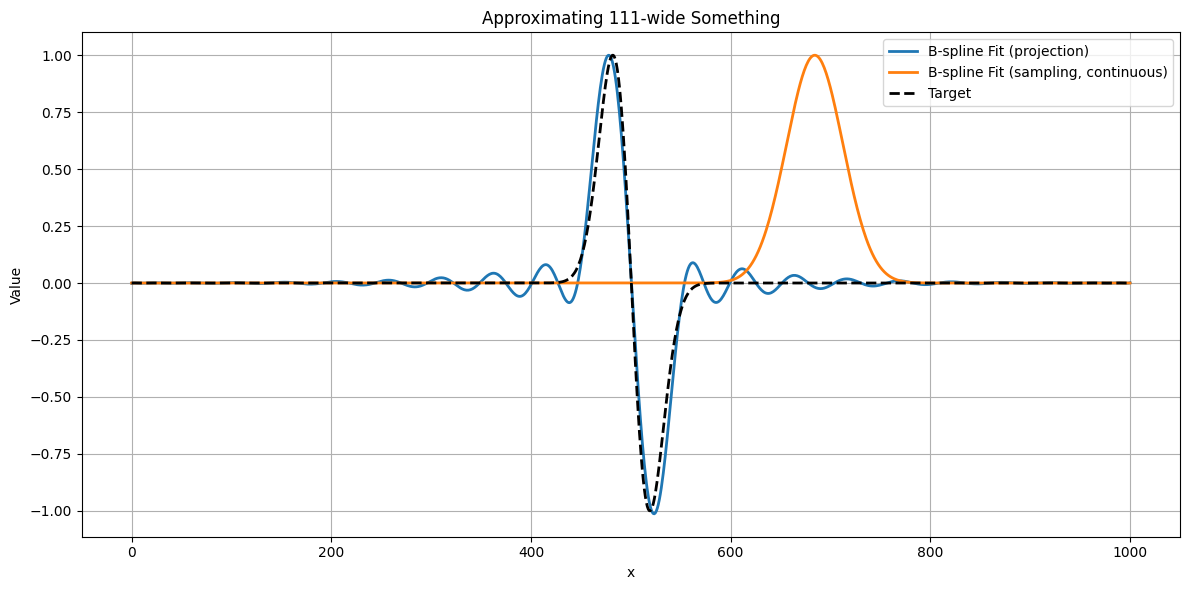

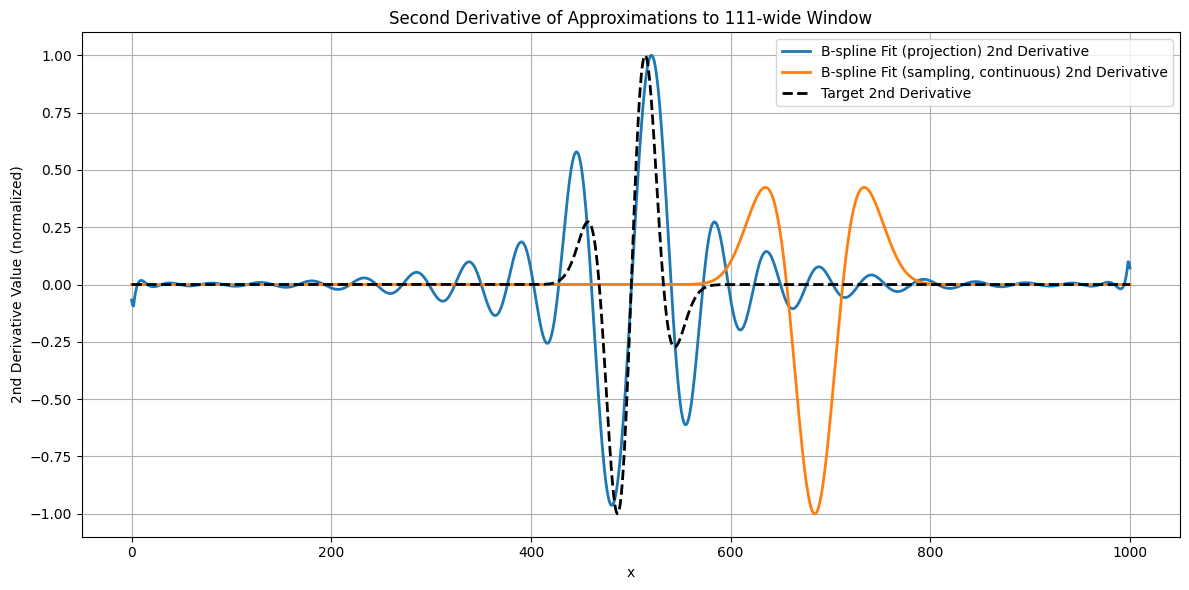

Target width: 397
28.051669003673652
Elapsed time: 0.0008 seconds
Elapsed time: 0.0001 seconds


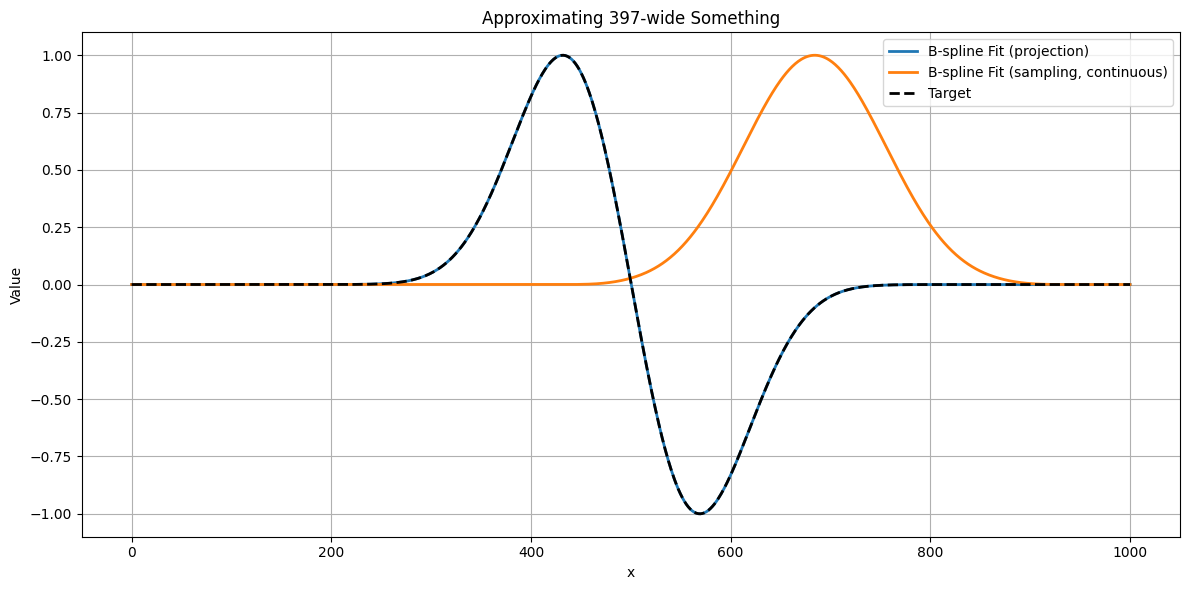

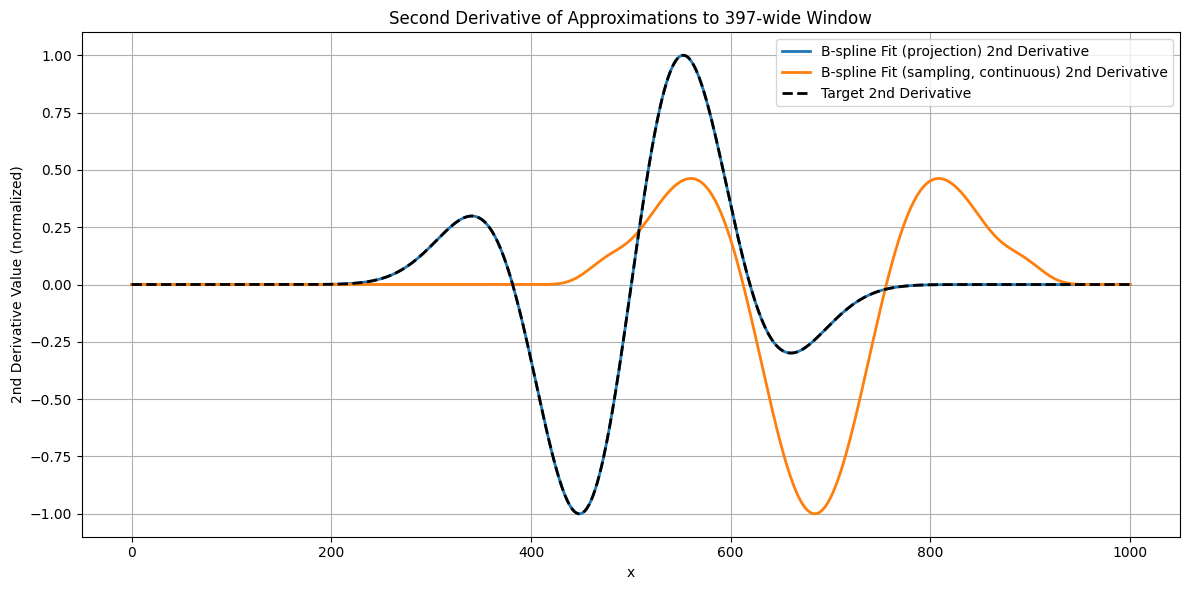

Target width: 728
7.990822364448736
Elapsed time: 0.0008 seconds
Elapsed time: 0.0001 seconds


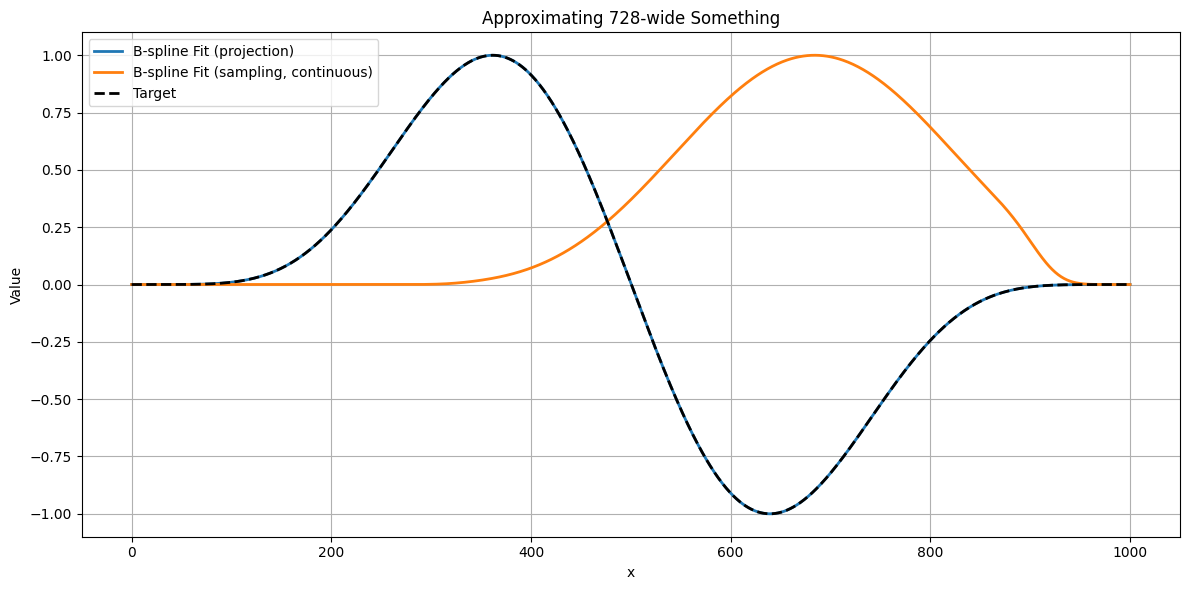

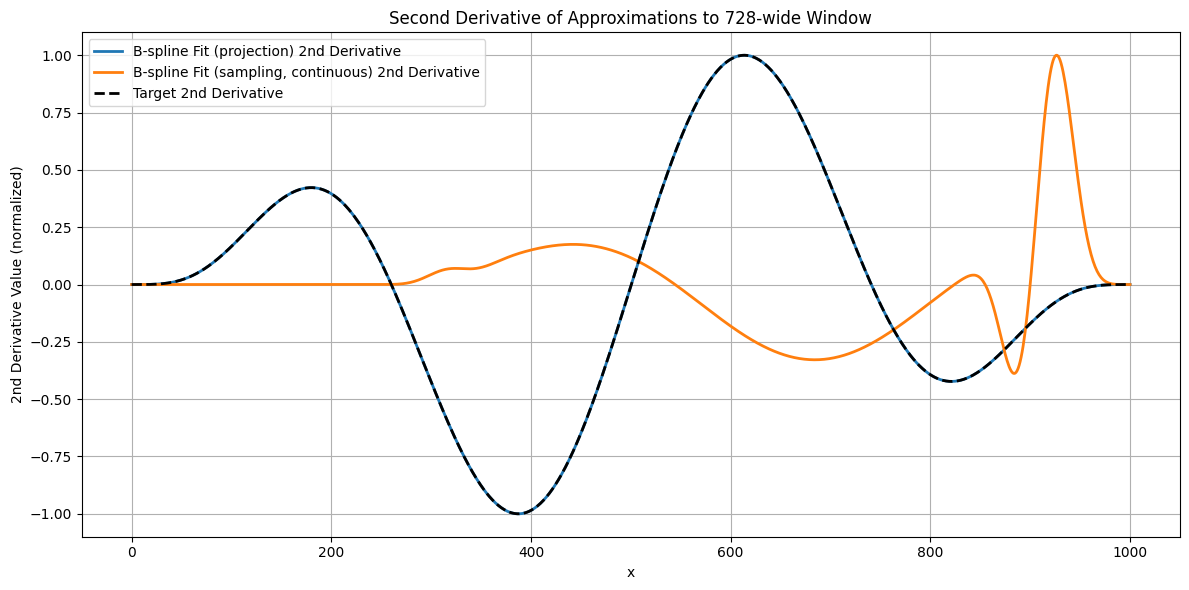

Target width: 1000
4.0
Elapsed time: 0.0010 seconds
Elapsed time: 0.0002 seconds


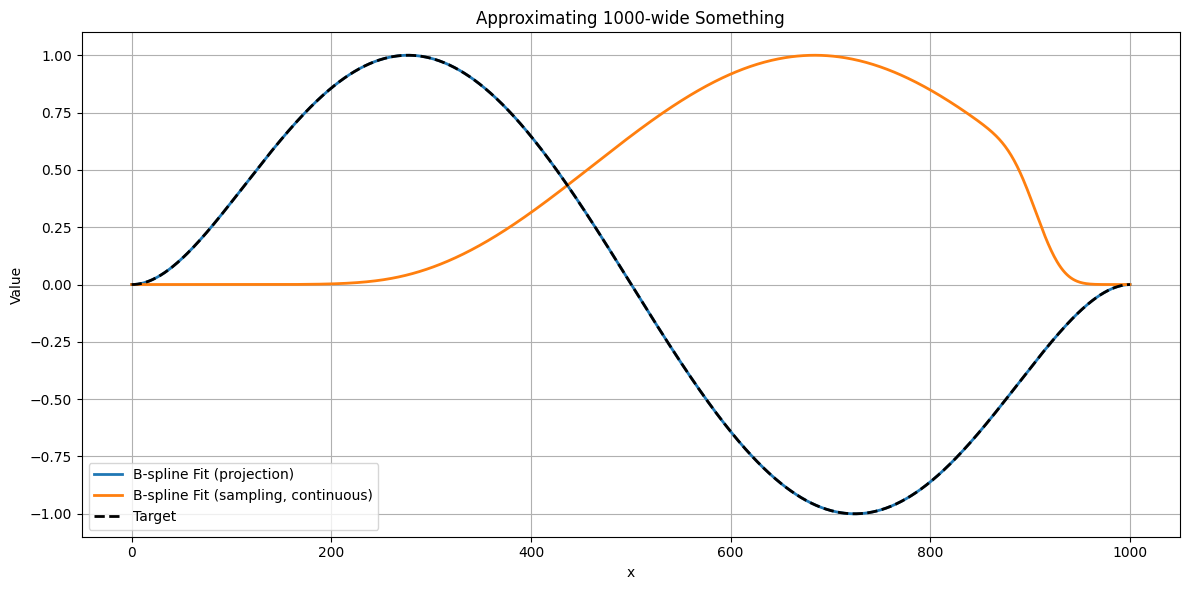

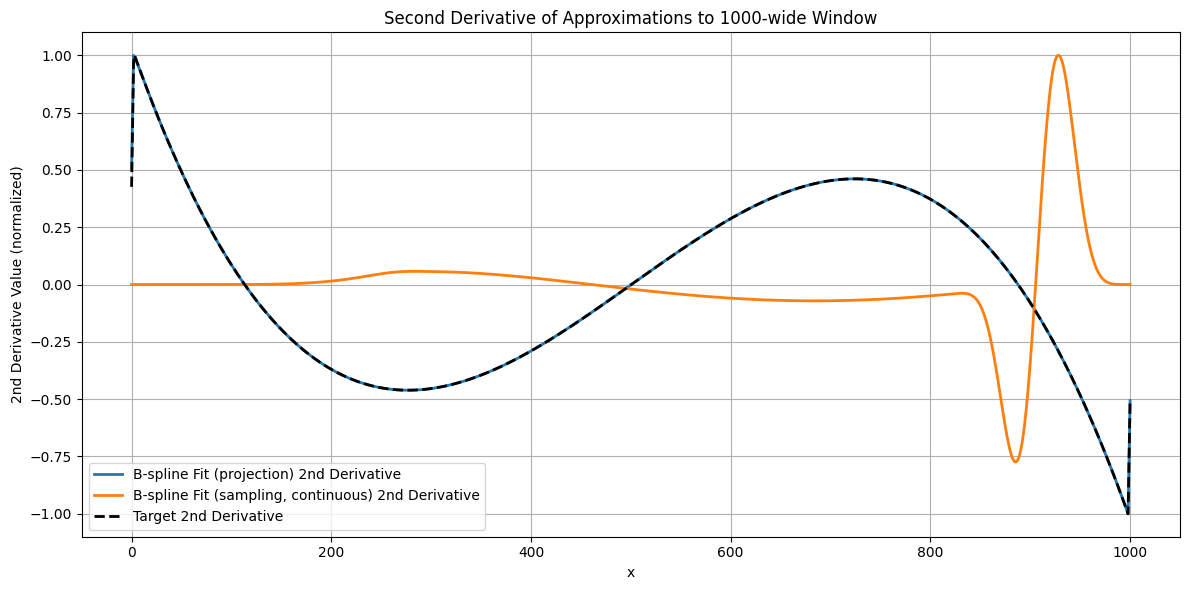

In [81]:
target_width = [111, 397, 728, 1000]
for width in target_width:
    print(f"Target width: {width}")

    # ---- Target: Window of specified width ----
    half_width = width // 2
    #target = 0.5 * (1 + np.cos(np.pi * (x - 500) / half_width))
    #target[np.abs(x - 500) > half_width] = 0
    """beta = 8.6         # Shape parameter (controls trade-off between mainlobe width and sidelobe level)
    window = windows.kaiser(width, beta)  #np.kaiser(width, beta)
    target = np.zeros_like(x)
    target[500 - half_width:500 + half_width] = window
    print(len(target[500 - half_width:500 + half_width]))
    print(len(window))
    def kaiser_value(x, N, beta):
        return iv(0, beta * np.sqrt(1 - ((2 * x / (N - 1)) - 1) ** 2)) / iv(0, beta)"""
    a = 1/2* ( (3000/width)**2 -1 )
    print(a)
    b = a
    target = beta.pdf(x/1000, a, b)
    target = np.concatenate([[0], np.diff(target)])
    #sigma = width / 6
    #target = norm.pdf(x, loc=500, scale=sigma)

    hann = 0.5 * (1 + np.cos(np.pi * (x - 500) / half_width))
    hann[np.abs(x - 500) > half_width] = 0

    # Cosine bumps
    #tic()
    #res_cosine = least_squares(objective_heights, initial_heights, args=(cosine_bumps, target), bounds=bounds)
    #cosine_fit = sum_bumps_with_coeffs(res_cosine.x, cosine_bumps)
    #print(res_cosine.x)

    #h_opt, *_ = np.linalg.lstsq(A_hann, target, rcond=None)
    #cosine_fit = A_hann @ h_opt
    #toc()

    # Project Hann onto B-spline basis using least squares
    #res_bspline = least_squares(objective_heights, np.ones(num_basis), args=(bspline_bumps, target_hann), bounds=bounds)
    #bspline_fit = sum_bumps_with_coeffs(res_bspline.x, bspline_bumps)
    tic()
    h_opt, *_ = np.linalg.lstsq(A_bspline, target, rcond=None)
    bspline_fit = A_bspline @ h_opt
    #print(res_bspline.x)
    toc()

    #tic()
    # Sample Hann at point closest to Greville abscissae 
    #idcs = greville.astype(int)
    #idcs[idcs < 0] = 0
    #idcs[idcs >= window_size] = window_size - 1
    #target_at_greville = target[idcs]
    # Evaluate final spline approximation
    #bspline_fit_2 = BSpline(knots, target_at_greville, spline_degree)(x)
    #target_at_greville = target_at_greville[2:-2]  # Remove the first 2 and last 2 B-spline bumps
    #bspline_fit_2_disc = sum_bumps_with_coeffs(target_at_greville, bspline_bumps)
    #toc()

    # Sample Hann at Greville abscissae
    tic()
    #target_at_greville = kaiser_value(greville-500+half_width, width, beta)
    #target_at_greville = 0.5 * (1 + np.cos(np.pi * (greville - 500) / half_width))
    target_at_greville = beta.pdf(greville/1000, a, b)
    target_at_greville[np.abs(greville - 500) > half_width] = 0
    target_at_greville[np.abs(greville - 500) > half_width] = 0
    #print(target_at_greville)
    bspline_fit_2_cont = sum_bumps_with_coeffs(target_at_greville, bspline_bumps)
    toc()

    #tic()
    #h_opt, *_ = np.linalg.lstsq(A_gaussian, target, rcond=None)
    #gaussian_fit = A_gaussian @ h_opt
    
    #res_gaussian = least_squares(objective_gaussian, initial_params, args=(x, cosine_centers, target), bounds=bounds)
    #res_gaussian = least_squares(objective_heights, initial_heights, args=(gaussian_bumps, target), bounds=bounds)
    #opt_heights = res_gaussian.x[:len(cosine_centers)]
    #opt_heights = res_gaussian.x
    #opt_widths = res_gaussian.x[len(cosine_centers):]
    #gaussian_fit = sum(gaussian_bump(x, c, w) * h for c, w, h in zip(cosine_centers, opt_widths, opt_heights))
    #gaussian_fit = sum(gaussian_bump(x, c, w) * h for c, w, h in zip(cosine_centers, len(cosine_centers)*[gaussian_width], opt_heights))
    #gaussian_fit = sum_bumps_with_coeffs(res_gaussian.x, gaussian_bumps)
    #toc()

    #tic()
    #h_opt, *_ = np.linalg.lstsq(A_bezier, target, rcond=None)
    #bezier_fit = A_bezier @ h_opt
    #toc()

    # ---- Plot ----

    plt.figure(figsize=(12, 6))
    #plt.plot(x, cosine_fit / np.max(cosine_fit), label='Cosine Fit (height only)', linewidth=2)
    plt.plot(x, bspline_fit / np.max(bspline_fit), label='B-spline Fit (projection)', linewidth=2)
    #plt.plot(x, bspline_fit_2_disc / np.max(bspline_fit_2_disc), label='B-spline Fit (sampling, discrete)', linewidth=2)
    plt.plot(x, bspline_fit_2_cont / np.max(bspline_fit_2_cont), label='B-spline Fit (sampling, continuous)', linewidth=2)
    #plt.plot(x, gaussian_fit / np.max(gaussian_fit), label='Gaussian Fit (height + width)', linewidth=2)
    #plt.plot(x, bezier_fit / np.max(bezier_fit), label='Bezier Fit (height + width)', linewidth=2)
    plt.plot(x, target / np.max(target), 'k--', label='Target', linewidth=2)
    plt.title(f"Approximating {width}-wide Something")
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Compute second derivative (numerically)
    dx = x[1] - x[0]  # Assuming uniform spacing
    #cosine_fit_2nd_derivative = np.gradient(np.gradient(cosine_fit, dx), dx)
    bspline_fit_2nd_derivative = np.gradient(np.gradient(bspline_fit, dx), dx)
    #bspline_fit_2_disc_2nd_derivative = np.gradient(np.gradient(bspline_fit_2_disc, dx), dx)
    bspline_fit_2_cont_2nd_derivative = np.gradient(np.gradient(bspline_fit_2_cont, dx), dx)
    #gaussian_fit_2nd_derivative = np.gradient(np.gradient(gaussian_fit, dx), dx)
    target_2nd_derivative = np.gradient(np.gradient(target, dx), dx)

    # Plot the second derivatives
    plt.figure(figsize=(12, 6))
    #plt.plot(x, cosine_fit_2nd_derivative / np.max(np.abs(cosine_fit_2nd_derivative)), label='Cosine Fit 2nd Derivative', linewidth=2)
    plt.plot(x, bspline_fit_2nd_derivative / np.max(np.abs(bspline_fit_2nd_derivative)), label='B-spline Fit (projection) 2nd Derivative', linewidth=2)
    #plt.plot(x, bspline_fit_2_disc_2nd_derivative / np.max(np.abs(bspline_fit_2_disc_2nd_derivative)), label='B-spline Fit (sampling, discrete) 2nd Derivative', linewidth=2)
    plt.plot(x, bspline_fit_2_cont_2nd_derivative / np.max(np.abs(bspline_fit_2_cont_2nd_derivative)), label='B-spline Fit (sampling, continuous) 2nd Derivative', linewidth=2)
    #plt.plot(x, gaussian_fit_2nd_derivative / np.max(np.abs(gaussian_fit_2nd_derivative)), label='Gaussian Fit 2nd Derivative', linewidth=2)
    plt.plot(x, target_2nd_derivative / np.max(np.abs(target_2nd_derivative)), 'k--', label='Target 2nd Derivative', linewidth=2)
    plt.title(f"Second Derivative of Approximations to {width}-wide Window")
    plt.xlabel('x')
    plt.ylabel('2nd Derivative Value (normalized)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    i += 1

In [ ]:
coeffs = np.ones(len(cosine_centers))
coeffs[[0, 1, 2, 3, -2, -1]] = 0
some_hann_bumps = sum_bumps_with_coeffs(coeffs, cosine_bumps)
plt.figure(figsize=(12, 6))
plt.plot(x, some_hann_bumps, label='Some Cosine Bumps', linewidth=2)
plot_dfts(
        x,
        some_hann_bumps,
        labels=[
            'just some cosine bumps',
        ],
        width="?"
    )